# Channel Merging Example

This notebook demonstrates the complete workflow for generating a mesh with VEWs from channel, non-channel, and background meshes. If you are reading this as an HTML document, it is exported from the jupyter notebook `example.ipynb`. The shell script `example.sh` also performs the same operations.


## Overview

The workflow consists of 9 main steps:
1. Combining channel and non-channel meshes with VEWs
2. Combining channel and non-channel meshes by merging overlapping nodes
3. Subtracting channel + non-channel coverage from background
4. Merging channel, non-channel, and subtracted background
5. Adding land boundaries to the merged mesh
6. Ensuring elevations of VEW channel nodes to be lower than bank nodes
7. Adjusting VEW barrier heights to be above the bank nodes
8. Copying nodal attributes in the background mesh to the new mesh
9. Updating Manning's n values in the new mesh

Let's go through each step with explanations and visualizations.

Create an output directory if it does not exist.

In [1]:
import os
cwd = os.getcwd()
output_dir = os.path.join(cwd, 'output')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Load common modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adcircpy import AdcircMesh
from adcircpy.mesh.fort13 import NodalAttributes
import subprocess

Set common parameters:

In [3]:
vmin = -10
vmax = 10
cmap = None
cmap = 'bwr'
extend = 'both'
lw = 1.0
xlim = [-77.895111, -77.277641]
ylim = [34.022876, 34.557258]

x2yratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])

ylim2 = [34.25, 34.35]
ylimdiff = ylim2[1] - ylim2[0]
xlim2 = [-77.70 - ylimdiff * x2yratio * 0.5, -77.70 + ylimdiff * x2yratio * 0.5]

ylim3 = [34.53, 34.57]
ylimdiff3 = ylim3[1] - ylim3[0]
xlim3 = [-77.3 - ylimdiff3 * x2yratio * 0.5, -77.3 + ylimdiff3 * x2yratio * 0.5]


Define common functions:

In [4]:
def plot_mesh(mesh_file, xlim2=xlim2, ylim2=ylim2, vmin=vmin, vmax=vmax, cmap=cmap, extend=extend, drawvew=False, drawland=False, fulldomain=False, title=None):
    """Plot an ADCIRC mesh with optional VEW and land boundaries at different zoom levels.
    
    """
    
    mesh = AdcircMesh.open(mesh_file)

    if fulldomain:
        figsize = (12.5*3/2-1, 6)
        subplot = [131, 132, 133]
    else:
        figsize = (12.5, 6)
        subplot = [121, 122]
        
    levels = np.arange(vmin, vmax, 0.5)

    cnt = 0

    fig = plt.figure(figsize=figsize)

    # Extent 1
    if fulldomain:
        axes = fig.add_subplot(subplot[cnt])
        axes = mesh.make_plot(axes=axes, vmin=vmin, vmax=vmax, cmap=cmap, extend=extend, levels=levels, title=title)
        axes = mesh.triplot(axes=axes)
        if drawvew:
            axes = mesh.boundaries.weir.gdf.plot(ax=axes, color='lightgreen', linewidth=lw, label='VEW')
            axes.legend()
        if drawland:
            axes = mesh.boundaries.land.gdf.plot(ax=axes, color='brown', linewidth=lw, label='Land')
            axes.legend()        
        axes.set_aspect('equal')
        cnt += 1
            
    # Extent 2
    axes = fig.add_subplot(subplot[cnt])
    axes = mesh.make_plot(axes=axes, vmin=vmin, vmax=vmax, cmap=cmap, extend=extend, levels=levels, title=title)
    axes = mesh.triplot(axes=axes)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if drawvew:
        axes = mesh.boundaries.weir.gdf.plot(ax=axes, color='lightgreen', linewidth=lw, label='VEW')
        axes.legend()
    if drawland:
        axes = mesh.boundaries.land.gdf.plot(ax=axes, color='brown', linewidth=lw, label='Land')
        axes.legend()
    axes.set_aspect('equal')
    cnt += 1

    # Extent 3
    axes = fig.add_subplot(subplot[cnt])
    axes = mesh.make_plot(axes=axes, vmin=vmin, vmax=vmax, cmap=cmap, extend=extend, levels=levels, title=title)
    axes = mesh.triplot(axes=axes)
    axes.set_xlim(xlim2)
    axes.set_ylim(ylim2)
    if drawvew:
        axes = mesh.boundaries.weir.gdf.plot(ax=axes, color='lightgreen', linewidth=lw, label='VEW')
        axes.legend()
    if drawland:
        axes = mesh.boundaries.land.gdf.plot(ax=axes, color='brown', linewidth=lw, label='Land')
        axes.legend()
    axes.set_aspect('equal')
    cnt += 1

    plt.tight_layout()
    plt.show()
    
    return axes

In [5]:
def plot_mannings_n(mesh_file, attrs_file, vmin=vmin, vmax=vmax, cmap=cmap, extend=extend, drawvew=False, drawland=False, fulldomain=False, title=None):
    """Plot Manning's n values from a mesh and fort.13 file.
    
    """
    
    # Load and plot the channel mesh
    mesh = AdcircMesh.open(mesh_file)
    
    attrs = NodalAttributes(mesh)
    attrs.import_fort13(attrs_file)

    get_loc = mesh.nodes.index.get_loc
    tri = [[get_loc(n_id) for n_id in tri] for tri in mesh.triangles.values]

    values = attrs.get_attribute('mannings_n_at_sea_floor')['values'].squeeze()


    if fulldomain:
        figsize = (12.5*3/2-1, 6)
        subplot = [131, 132, 133]
    else:
        figsize = (12.5, 6)
        subplot = [121, 122]
    
    levels = np.arange(vmin, vmax, 0.005)

    cnt = 0

    fig = plt.figure(figsize=figsize)

    # Extent 1
    if fulldomain:
        axes = fig.add_subplot(subplot[cnt])
        axes.tricontourf(mesh.nodes.x, mesh.nodes.y, tri, values, levels=levels, cmap=cmap, extend=extend, vmin=vmin, vmax=vmax)
        axes = mesh.triplot(axes=axes)
        if drawvew:
            axes = mesh.boundaries.weir.gdf.plot(ax=axes, color='lightgreen', linewidth=lw, label='VEW')
            axes.legend()
        if drawland:
            axes = mesh.boundaries.land.gdf.plot(ax=axes, color='brown', linewidth=lw, label='Land')
            axes.legend()        
        axes.set_title(title)
        axes.set_aspect('equal')
        mappable = ScalarMappable(cmap=cmap)
        mappable.set_array([])
        mappable.set_clim(vmin, vmax)
        divider = make_axes_locatable(axes)
        cax = divider.append_axes('bottom', size='2%', pad=0.5)
        cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
        cbar.set_ticks([vmin, vmax])
        cbar.set_ticklabels([np.around(vmin, 2), np.around(vmax, 2)])
        cnt += 1
            
    # Extent 2
    axes = fig.add_subplot(subplot[cnt])
    axes.tricontourf(mesh.nodes.x, mesh.nodes.y, tri, values, levels=levels, cmap=cmap, extend=extend, vmin=vmin, vmax=vmax)
    axes = mesh.triplot(axes=axes)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if drawvew:
        axes = mesh.boundaries.weir.gdf.plot(ax=axes, color='lightgreen', linewidth=lw, label='VEW')
        axes.legend()
    if drawland:
        axes = mesh.boundaries.land.gdf.plot(ax=axes, color='brown', linewidth=lw, label='Land')
        axes.legend()
    axes.set_title(title)
    axes.set_aspect('equal')
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(vmin, vmax)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('bottom', size='2%', pad=0.5)
    cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([np.around(vmin, 2), np.around(vmax, 2)])
    cnt += 1

    # Extent 3
    axes = fig.add_subplot(subplot[cnt])
    axes.tricontourf(mesh.nodes.x, mesh.nodes.y, tri, values, levels=levels, cmap=cmap, extend=extend, vmin=vmin, vmax=vmax)
    axes = mesh.triplot(axes=axes)
    axes.set_xlim(xlim2)
    axes.set_ylim(ylim2)
    
    if drawvew:
        axes = mesh.boundaries.weir.gdf.plot(ax=axes, color='lightgreen', linewidth=lw, label='VEW')
        axes.legend()
    if drawland:
        axes = mesh.boundaries.land.gdf.plot(ax=axes, color='brown', linewidth=lw, label='Land')
        axes.legend()
    axes.set_title(title)
    axes.set_aspect('equal')
    mappable = ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(vmin, vmax)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('bottom', size='2%', pad=0.5)
    cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([np.around(vmin, 2), np.around(vmax, 2)])
    cnt += 1

    plt.tight_layout()
    plt.show()
    
    return axes

## Step 0: Uncompress Input Files

Before proceeding, ensure you have uncompressed the required input files for this example. You can uncompress the input files by the following command:

```
bash P00_uncompress_files.sh
```

## Step 1: Combining Channel and Non-Channel Meshes with VEWs

First, we combine the channel and non-channel meshes. VEW boundaries are added along the interfaces of the two meshes.

Input mesh (channel):

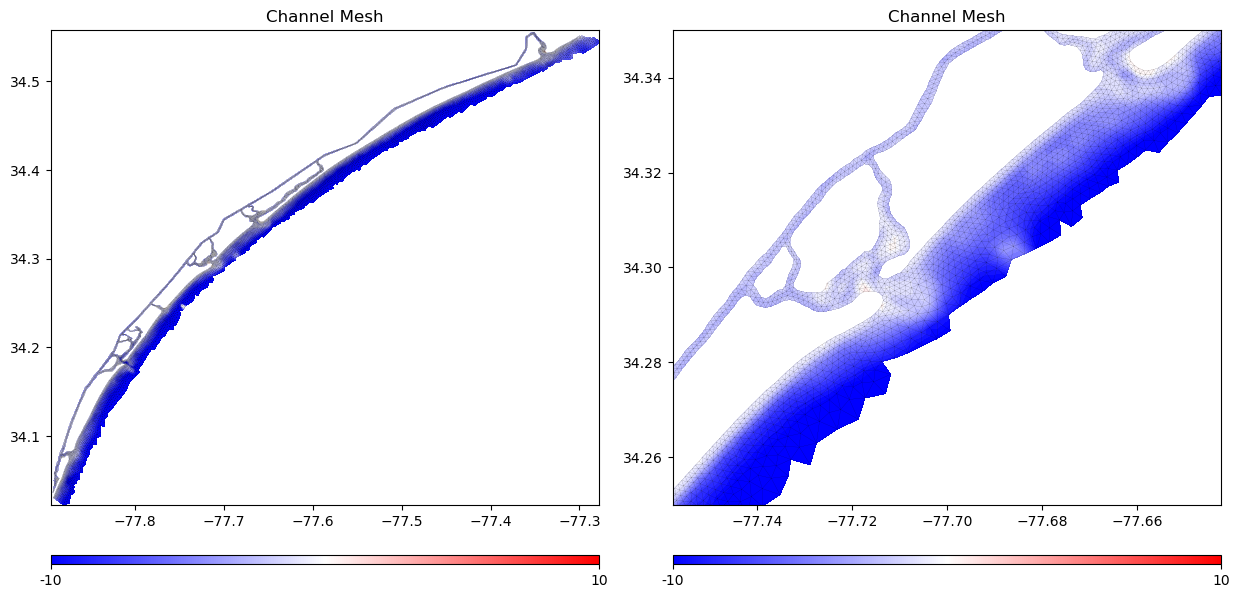

In [6]:
axes = plot_mesh('input/channel.14', title='Channel Mesh')

Input mesh (non-channel):

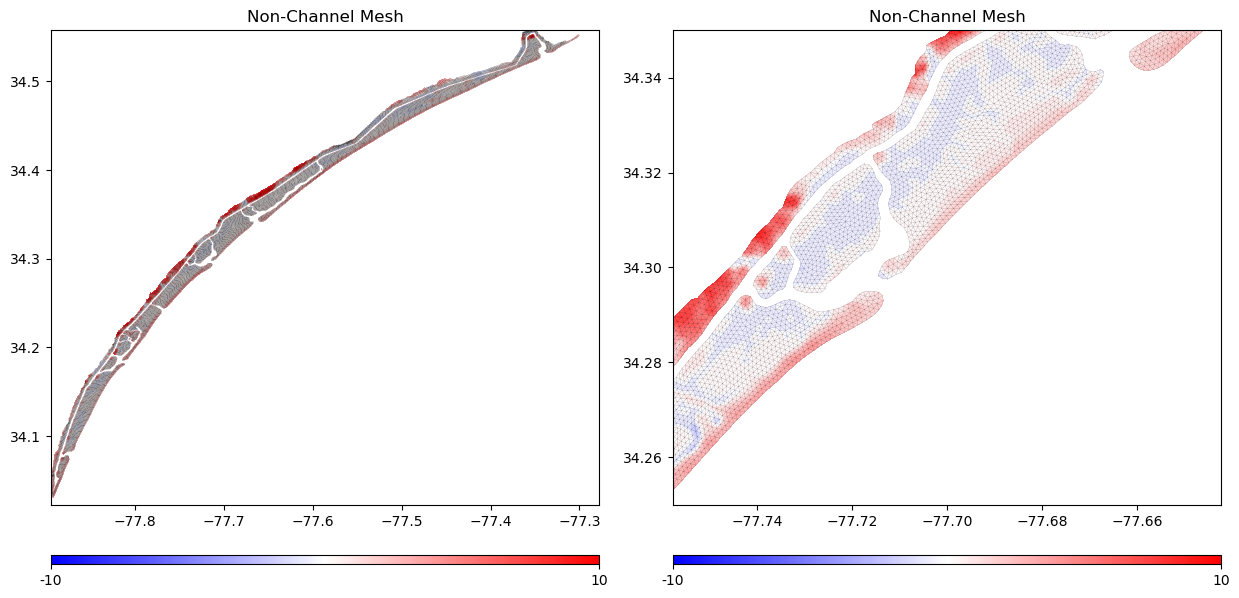

In [7]:
axes = plot_mesh('input/non-channel.14', title='Non-Channel Mesh')

Execute mesh_merger command:

In [8]:
# Combine channel and non-channel meshes with VEWs
# Equivalent to: python -m vewutils.mesh.mesh_merger input/channel.14 input/non-channel.14 -b vew -o output/ch_noch.14 -d 'merged: channel + non-channel with VEWs' 
from vewutils.mesh import mesh_merger
subprocess.run(['python', '-m', 'vewutils.mesh.mesh_merger', 
               'input/channel.14', 'input/non-channel.14',
               '-b', 'vew',
               '-o', 'output/ch_noch.14',
               '-d', 'merged: channel + non-channel with VEWs'])

Successfully read channel mesh from: input/channel.14
Successfully read land mesh from: input/non-channel.14

Channel mesh info:
Number of nodes: 10505
Number of elements: 17826

Land mesh info:
Number of nodes: 15710
Number of elements: 27617

Starting mesh merge with VEW boundaries...
Creating node mapping...
Combining nodes...
Combined nodes: 26215
Combining elements...
Combined elements: 45443
Finding matching nodes...
Found 2916 matching nodes
Updating boundary node numbers...
Removing matching nodes from boundaries...
Creating final merged mesh...
Finding paired nodes...
Found 2916 paired nodes
Creating VEW boundaries...
Adding VEW boundaries to mesh...
Added 16 VEW boundary segments
Merging endpoints of non-looped VEW boundaries...
Mesh merge complete!

Merged mesh info:
Number of nodes: 26213
Number of elements: 45443

Merged mesh saved to: output/ch_noch.14


CompletedProcess(args=['python', '-m', 'vewutils.mesh.mesh_merger', 'input/channel.14', 'input/non-channel.14', '-b', 'vew', '-o', 'output/ch_noch.14', '-d', 'merged: channel + non-channel with VEWs'], returncode=0)

Resulting mesh with VEWs:

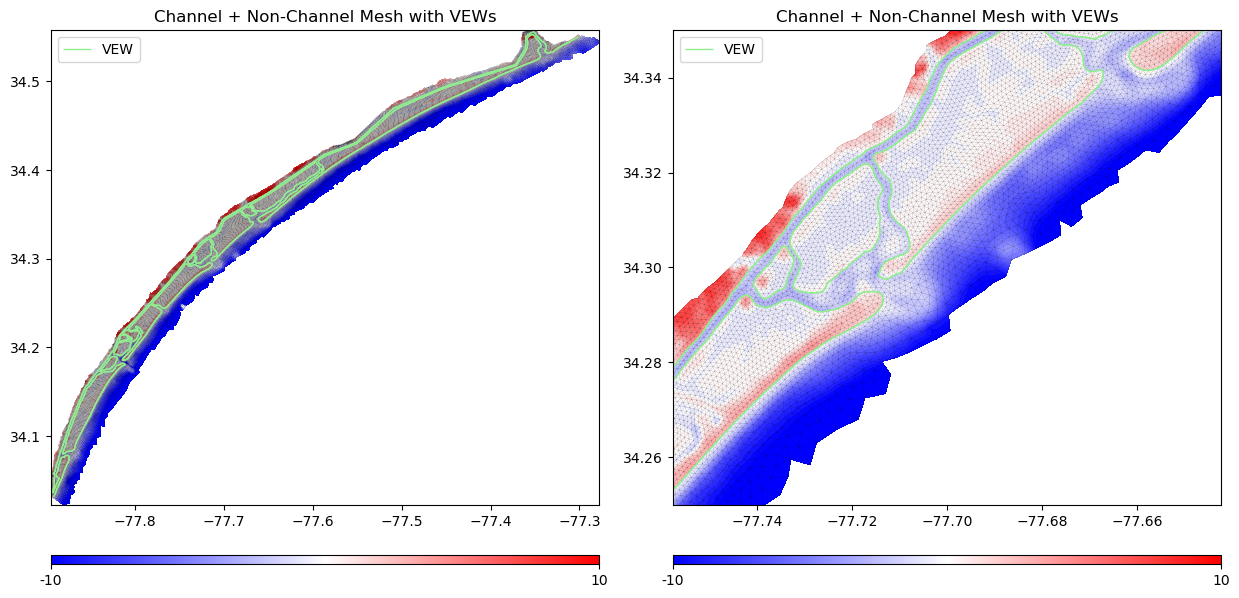

In [9]:
axes = plot_mesh('output/ch_noch.14', drawvew=True, title='Channel + Non-Channel Mesh with VEWs')

## Step 2: Combining Channel and Non-Channel Meshes by Merging Overlapping Nodes

Next, we combine the channel and non-channel meshes by merging overlapping nodes. This merged mesh is used later for defining the extent of the added mesh for updating Manning's n values.

In [10]:
# Combine channel and non-channel meshes by merging overlapping nodes
# Equivalent to: python -m vewutils.mesh.mesh_merger input/channel.14 input/non-channel.14 -b merge -o output/ch_noch_mgd.14 -d 'merged: channel + non-channel with merged nodes'
subprocess.run(['python', '-m', 'vewutils.mesh.mesh_merger',
               'input/channel.14', 'input/non-channel.14', 
               '-b', 'merge',
               '-o', 'output/ch_noch_mgd.14',
               '-d', 'merged: channel + non-channel with merged nodes'])

Successfully read channel mesh from: input/channel.14
Successfully read land mesh from: input/non-channel.14

Channel mesh info:
Number of nodes: 10505
Number of elements: 17826

Land mesh info:
Number of nodes: 15710
Number of elements: 27617

Starting mesh merge with node merging...
Finding matching nodes...
Found 2916 matching nodes
Creating node mapping...
Combining nodes...
Updating values at matching nodes using channel mesh values...
Adding non-matching nodes...
Combined nodes: 23299
Updating element connectivity...
Combined elements: 45443
Updating boundary node numbers...
Finding boundary edges in final mesh...
Removing non-boundary nodes...
Creating final merged mesh...
Merged 2916 duplicate nodes
Used channel mesh values at 2916 matching nodes
Mesh merge complete!

Merged mesh info:
Number of nodes: 23299
Number of elements: 45443

Merged mesh saved to: output/ch_noch_mgd.14


CompletedProcess(args=['python', '-m', 'vewutils.mesh.mesh_merger', 'input/channel.14', 'input/non-channel.14', '-b', 'merge', '-o', 'output/ch_noch_mgd.14', '-d', 'merged: channel + non-channel with merged nodes'], returncode=0)

Resulting mesh with merged nodes:

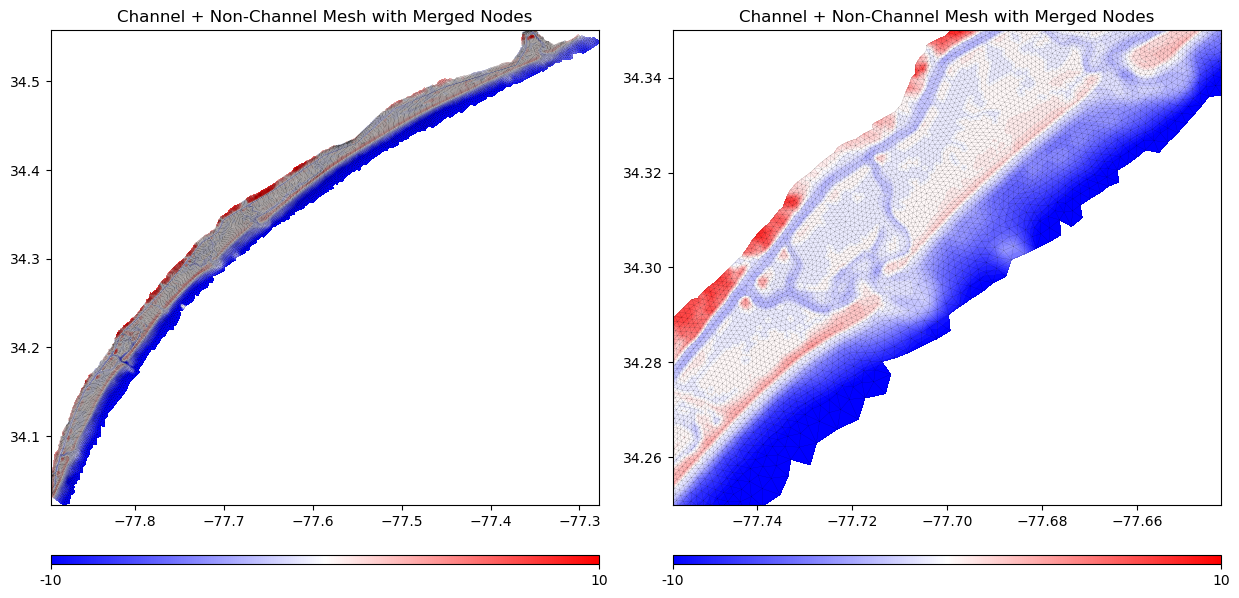

In [11]:
axes = plot_mesh('output/ch_noch_mgd.14', title='Channel + Non-Channel Mesh with Merged Nodes')

## Step 3: Subtracting Channel + Non-Channel Coverage from Background

Now we subtract the channel and non-channel coverage from the background mesh.

In [12]:
# Subtract channel and non-channel coverage from background mesh
# Equivalent to: python -m vewutils.mesh.mesh_subtractor input/background.14 output/ch_noch_mgd.14 -o output/background_subtracted.14 -d 'subtracted: background - (channel + land)'
subprocess.run(['python', '-m', 'vewutils.mesh.mesh_subtractor',
               'input/background.14', 'output/ch_noch_mgd.14',
               '-o', 'output/background_subtracted.14', 
               '-d', 'subtracted: background - (channel + non-channel)'])

Starting mesh subtraction process...
Finding boundary edges of mesh B...
Found 1153 boundary edges
Splitting boundary into segments...
Found 1 boundary segments
Generating boundary polygon for mesh B...
Boundary polygon generated
Calculating element centroids...
Testing containment of element centroids...
Found 1598517 elements to keep out of 1656634
Creating new mesh with remaining elements...
Renumbering nodes...
Creating final mesh object...
Mesh subtraction complete!
Original mesh: 1656634 elements, 886541 nodes
Result mesh: 1598517 elements, 858058 nodes
Subtracted mesh written to output/background_subtracted.14


CompletedProcess(args=['python', '-m', 'vewutils.mesh.mesh_subtractor', 'input/background.14', 'output/ch_noch_mgd.14', '-o', 'output/background_subtracted.14', '-d', 'subtracted: background - (channel + non-channel)'], returncode=0)

Resulting mesh:

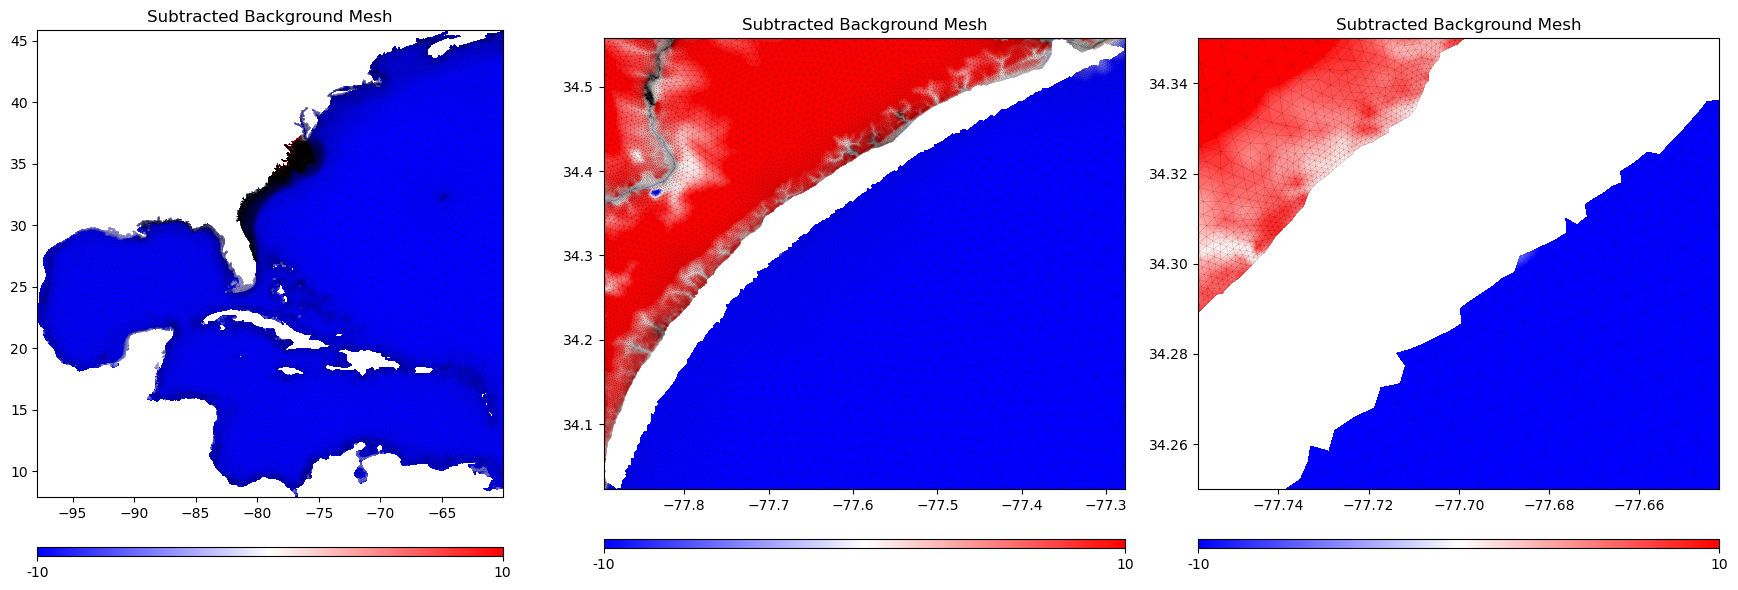

In [13]:
axes = plot_mesh('output/background_subtracted.14', fulldomain=True, title='Subtracted Background Mesh')

## Step 4: Merging Channel, non-channel, and Subtracted Background

We now merge the channel, non-channel, and subtracted background meshes.

In [14]:
# Merge channel, non-channel, and subtracted background meshes
# Equivalent to: python -m vewutils.mesh.mesh_merger output/ch_noch.14 output/background_subtracted.14 -b merge -o output/ch_noch_bg.14 -d 'merged: background_subtracted + channel + land'
subprocess.run(['python', '-m', 'vewutils.mesh.mesh_merger',
               'output/ch_noch.14', 'output/background_subtracted.14',
               '-b', 'merge',
               '-o', 'output/ch_noch_bg.14',
               '-d', 'merged: background_subtracted + channel + non-channel'])

Successfully read channel mesh from: output/ch_noch.14
Successfully read land mesh from: output/background_subtracted.14

Channel mesh info:
Number of nodes: 26213
Number of elements: 45443

Land mesh info:
Number of nodes: 858058
Number of elements: 1598517

Starting mesh merge with node merging...
Finding matching nodes...
Found 1153 matching nodes
Creating node mapping...
Combining nodes...
Updating values at matching nodes using channel mesh values...
Adding non-matching nodes...
Combined nodes: 883118
Updating element connectivity...
Combined elements: 1643960
Updating boundary node numbers...
Finding boundary edges in final mesh...
Removing non-boundary nodes...
Creating final merged mesh...
Merged 1153 duplicate nodes
Used channel mesh values at 1153 matching nodes
Mesh merge complete!

Merged mesh info:
Number of nodes: 883118
Number of elements: 1643960

Merged mesh saved to: output/ch_noch_bg.14


CompletedProcess(args=['python', '-m', 'vewutils.mesh.mesh_merger', 'output/ch_noch.14', 'output/background_subtracted.14', '-b', 'merge', '-o', 'output/ch_noch_bg.14', '-d', 'merged: background_subtracted + channel + non-channel'], returncode=0)

Resulting mesh:

/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/tmp/ipykernel_1527791/2483589787.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


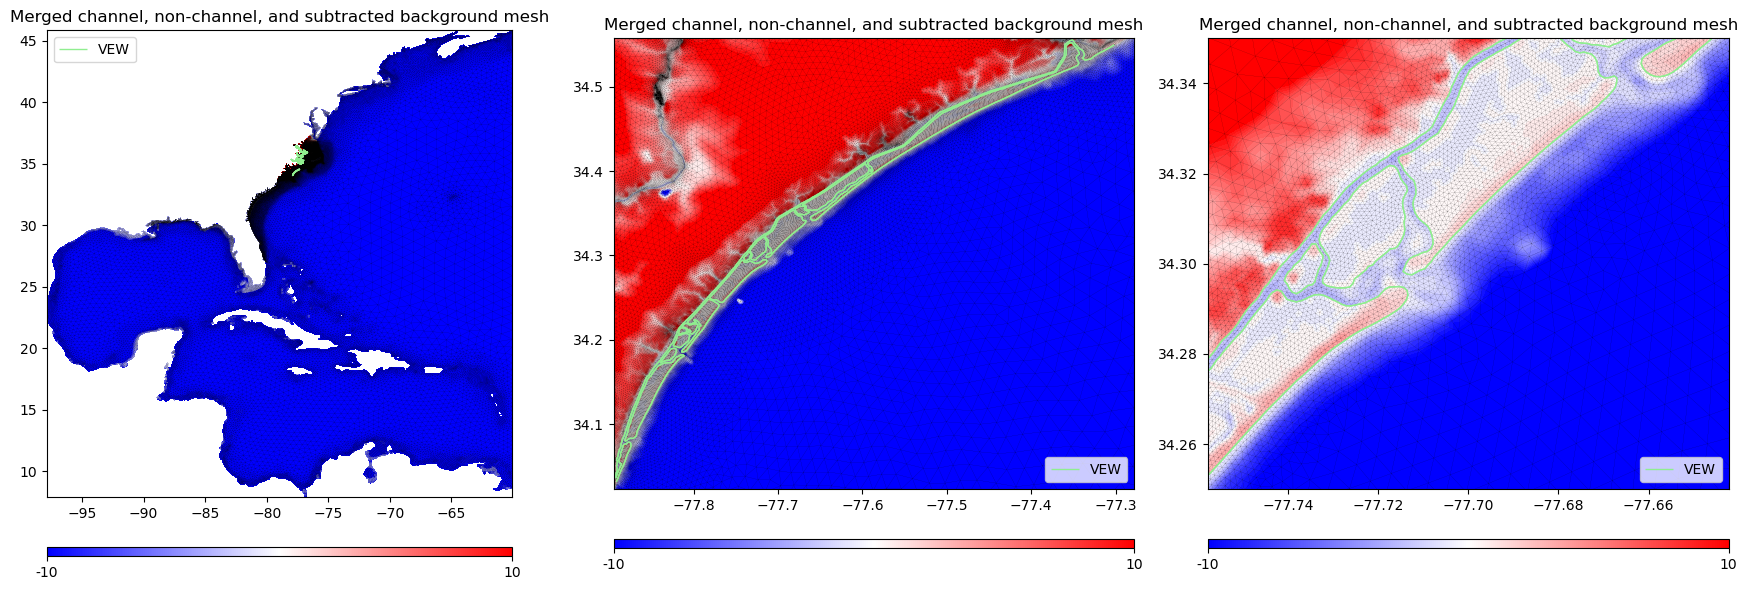

In [15]:
axes = plot_mesh('output/ch_noch_bg.14', drawvew=True, fulldomain=True, title='Merged channel, non-channel, and subtracted background mesh')

## Step 5: Adding Land Boundaries to the Merged Mesh

Next, we add land boundaries to the merged mesh.

In [16]:
# Add land boundaries to the merged mesh
# Equivalent to: python -m vewutils.mesh.add_land_boundaries output/ch_noch_bg.14 -o output/ch_noch_bg_lb.14 -d 'merged: background_subtracted + channel + non-channel with land boundaries'
subprocess.run(['python', '-m', 'vewutils.mesh.add_land_boundaries',
               'output/ch_noch_bg.14',
               '-o', 'output/ch_noch_bg_lb.14',
               '-d', 'merged: background_subtracted + channel + non-channel with land boundaries'])

Reading input mesh...
Successfully read mesh from: output/ch_noch_bg.14

Input mesh info:
Number of nodes: 883118
Number of elements: 1643960
Computing mesh topology...
Found 122572 boundary edges and 122572 boundary nodes

Starting to add land boundaries...
Finding boundary nodes...
Found 122572 boundary nodes
Finding nodes with existing boundary conditions...
Found 120367 nodes with existing boundary conditions
Found 2211 endpoints of unassigned boundary edges
Found 2211 unassigned boundary nodes (including relevant endpoints)
Splitting nodes into continuous segments...
Split into 3 continuous segments
Creating land boundary definitions...
  Created land boundary 1 with 2205 nodes
  Created land boundary 2 with 3 nodes
  Created land boundary 3 with 3 nodes
Adding land boundaries to mesh...
  Appending to existing land boundaries...
Creating new mesh with added boundaries...

Successfully added 3 land boundary segments
Land boundary addition complete!

Output mesh info:
Number of nod

CompletedProcess(args=['python', '-m', 'vewutils.mesh.add_land_boundaries', 'output/ch_noch_bg.14', '-o', 'output/ch_noch_bg_lb.14', '-d', 'merged: background_subtracted + channel + non-channel with land boundaries'], returncode=0)

Resulting mesh:

/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/tmp/ipykernel_1527791/2483589787.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


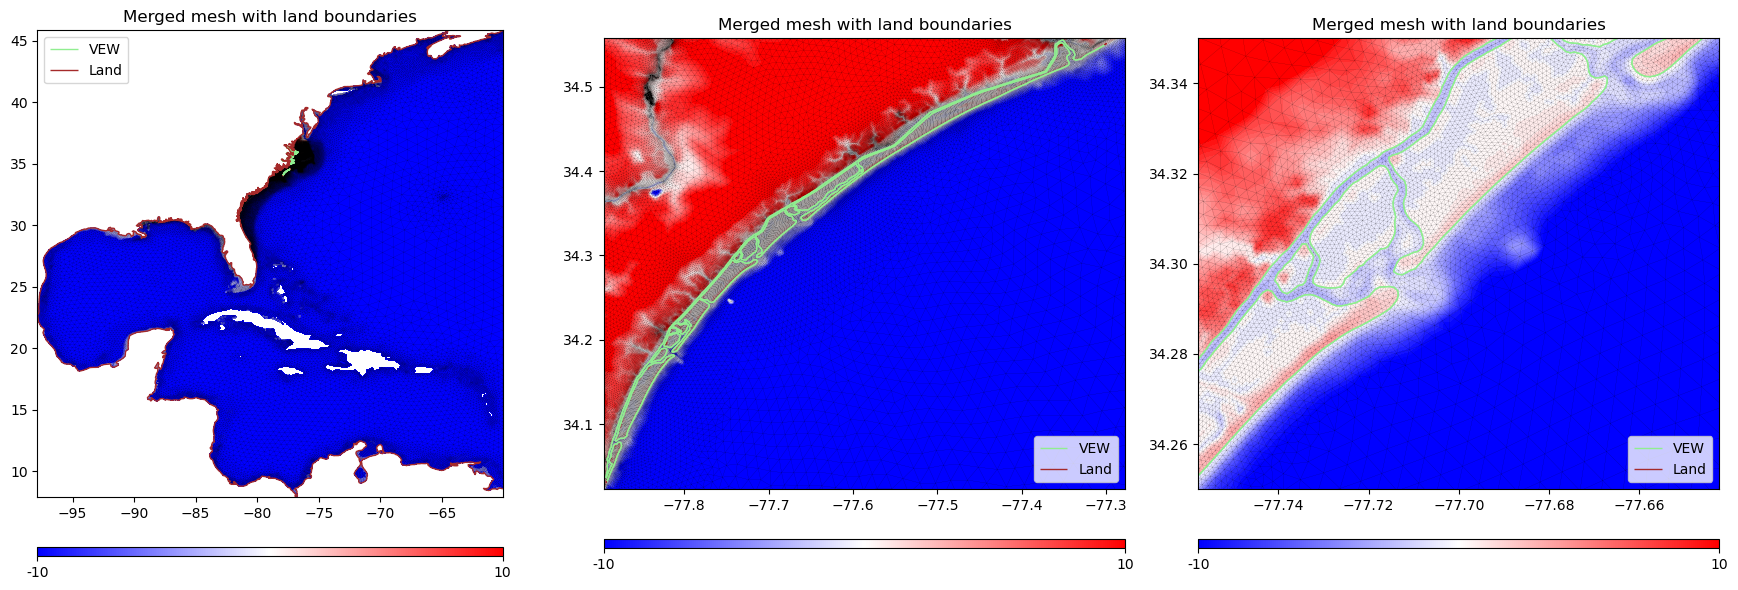

In [17]:
axes = plot_mesh('output/ch_noch_bg_lb.14', drawvew=True, drawland=True, fulldomain=True, title='Merged mesh with land boundaries')

## Step 6: Ensuring Elevations of VEW Channel Nodes

We ensure that the elevations of VEW channel nodes are lower than bank nodes.

In [18]:
# Adjust VEW channel elevations
# Equivalent to: python -m vewutils.mesh.adjust_vew_channel_elevations output/ch_noch_bg_lb.14 -o output/ch_noch_bg_lb_adjusted1.14
subprocess.run(['python', '-m', 'vewutils.mesh.adjust_vew_channel_elevations',
               'output/ch_noch_bg_lb.14',
               '-o', 'output/ch_noch_bg_lb_adjusted1.14'])


Number of channel nodes altered: 16
Modified mesh saved to: output/ch_noch_bg_lb_adjusted1.14


CompletedProcess(args=['python', '-m', 'vewutils.mesh.adjust_vew_channel_elevations', 'output/ch_noch_bg_lb.14', '-o', 'output/ch_noch_bg_lb_adjusted1.14'], returncode=0)

Resulting mesh:

/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/tmp/ipykernel_1527791/2483589787.py:65: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


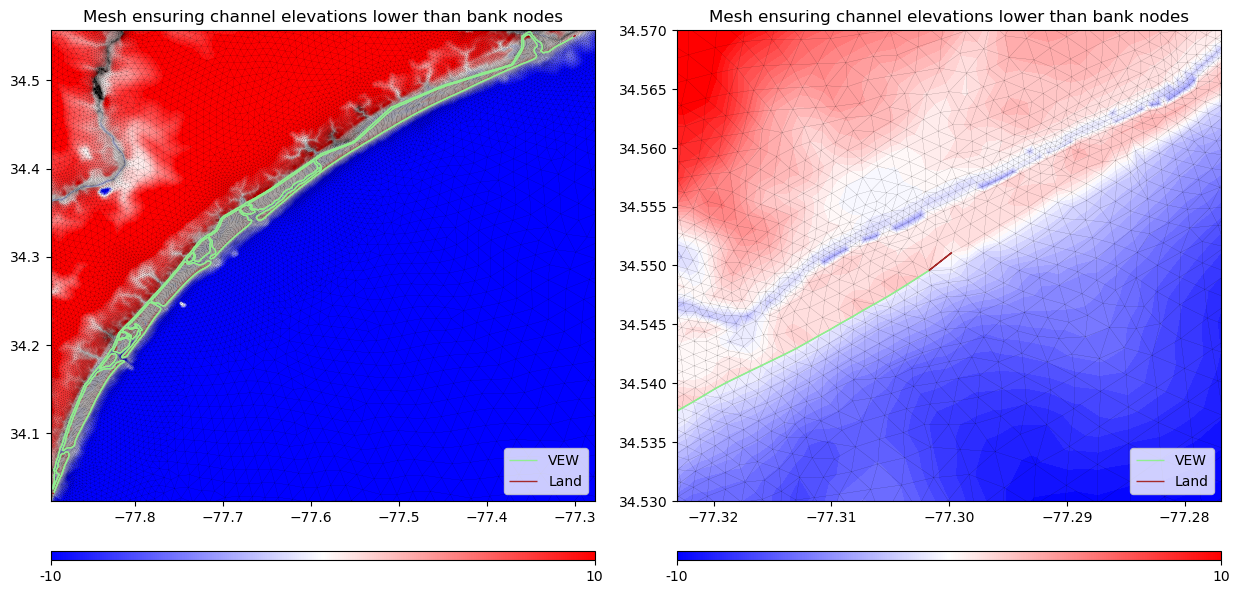

In [19]:
axes = plot_mesh('output/ch_noch_bg_lb_adjusted1.14', xlim2=xlim3, ylim2=ylim3, drawvew=True, drawland=True, title='Mesh ensuring channel elevations lower than bank nodes')

Land boundaries (ibtype=20) should be applied at the ends of un-looped VEWs. This is not necessary when the mesh is used in ADCIRC only simulations. This application of land boundaries at the tips of un-looped VEWs is needed for ADCIRC-SWAN coupled simulations. SWAN gives segmentation fault if the land boundary is not given properly.

## Step 7: Adjusting VEW Barrier Heights

We adjust VEW barrier heights to be above the bank nodes.

In [20]:
# Adjust VEW barrier heights
# Equivalent to: python -m vewutils.mesh.adjust_vew_barrier_heights output/ch_noch_bg_lb_adjusted1.14 -o output/ch_noch_bg_lb_adjusted2.14

subprocess.run(['python', '-m', 'vewutils.mesh.adjust_vew_barrier_heights',
               'output/ch_noch_bg_lb_adjusted1.14',
               '-o', 'output/ch_noch_bg_lb_adjusted2.14'])

Number of barrier heights set: 53464
Modified mesh saved to: output/ch_noch_bg_lb_adjusted2.14


CompletedProcess(args=['python', '-m', 'vewutils.mesh.adjust_vew_barrier_heights', 'output/ch_noch_bg_lb_adjusted1.14', '-o', 'output/ch_noch_bg_lb_adjusted2.14'], returncode=0)

## Step 8: Copying Nodal Attributes

We copy nodal attributes from the background mesh to the new mesh.

In [21]:
# Copy nodal attributes from background mesh to new mesh
# Equivalent to: python -m vewutils.nodalattribute.attribute_transfer input/background.14 input/background.13 output/ch_noch_bg_lb_adjusted2.14 -o output/ch_noch_bg_lb_adjusted2.13
subprocess.run(['python', '-m', 'vewutils.nodalattribute.attribute_transfer',
               'input/background.14',
               'input/background.13', 
               'output/ch_noch_bg_lb_adjusted2.14',
               '-o', 'output/ch_noch_bg_lb_adjusted2.13'])

Loading source mesh and attributes...
Loading target mesh...
Building conversion tables...
Transferring attributes...
Processing attribute: surface_directional_effective_roughness_length
Processing attribute: surface_canopy_coefficient
Processing attribute: mannings_n_at_sea_floor
Processing attribute: primitive_weighting_in_continuity_equation
Processing attribute: average_horizontal_eddy_viscosity_in_sea_water_wrt_depth
Processing attribute: elemental_slope_limiter
Processing attribute: wave_refraction_in_swan
Processing attribute: sea_surface_height_above_geoid
Processing attribute: initial_river_elevation
Processing attribute: overland_reduction_factor
Processing attribute: advection_state
Processing attribute: condensed_nodes
Writing output to output/ch_noch_bg_lb_adjusted2.13...
Done!


CompletedProcess(args=['python', '-m', 'vewutils.nodalattribute.attribute_transfer', 'input/background.14', 'input/background.13', 'output/ch_noch_bg_lb_adjusted2.14', '-o', 'output/ch_noch_bg_lb_adjusted2.13'], returncode=0)

Resulting nodal attribute values (Manning's n):

/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/tmp/ipykernel_1527791/3944871649.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


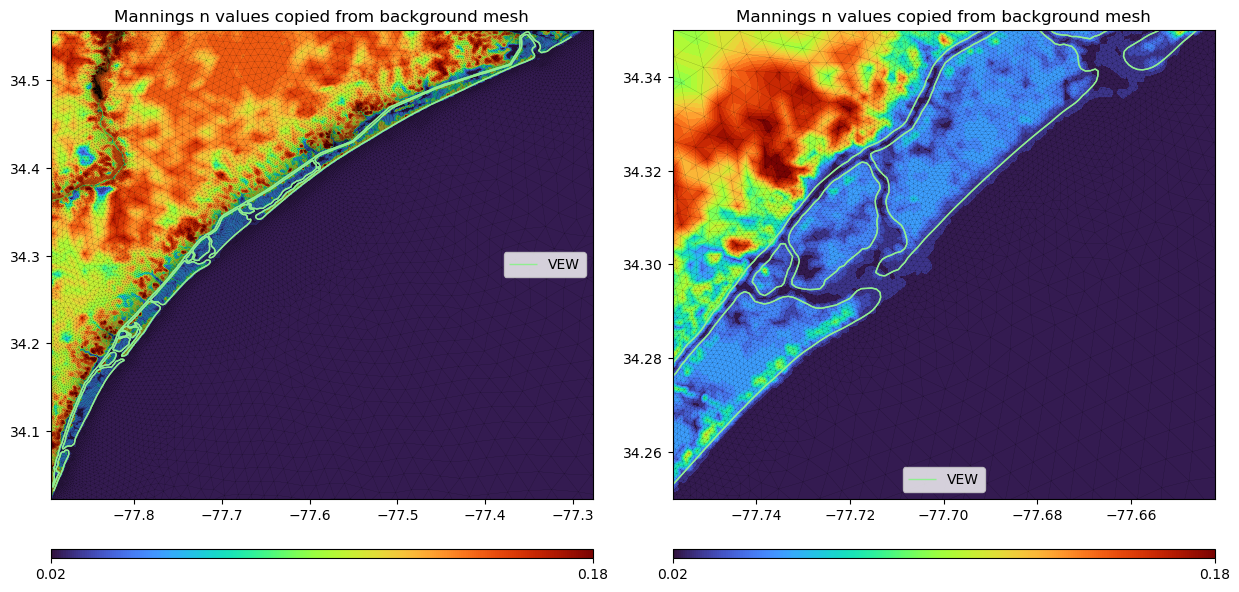

In [22]:
axes = plot_mannings_n('output/ch_noch_bg_lb_adjusted2.14', 'output/ch_noch_bg_lb_adjusted2.13', drawvew=True, cmap='turbo', vmin=0.02, vmax=0.18, title='Mannings n values copied from background mesh')

## Step 9: Updating Manning's n Values

Finally, we update Manning's n values in the new mesh. This step has two substeps:
1. Selecting channel mesh nodes from the new mesh
2. Updating Manning's n values at the selected nodes

### Step 9.1: Selecting Channel Mesh Nodes

First, we select the channel mesh nodes from the new mesh.

In [23]:
# Select channel mesh nodes
# Equivalent to: python -m vewutils.utils.node_selector output/ch_noch_bg_lb_adjusted2.14 -o output/ch_noch_bg_lb_adjusted2_channel_mesh_nodes.csv -m output/ch_noch_mgd.14
subprocess.run(['python', '-m', 'vewutils.utils.node_selector',
               'output/ch_noch_bg_lb_adjusted2.14',
               '-o', 'output/ch_noch_bg_lb_adjusted2_channel_mesh_nodes.csv',
               '-m', 'output/ch_noch_mgd.14'])


Loading mesh: output/ch_noch_bg_lb_adjusted2.14
Mesh loaded: 883118 nodes, 1643960 elements

Selecting nodes by mesh boundary...
Loading boundary mesh: output/ch_noch_mgd.14
Generating boundary polygon...
Finding unshared edges...
Found 1153 boundary edges
Creating boundary segments...
Found 1 boundary segments
Creating boundary polygons...
Merging boundary polygons...
Creating buffered boundary...
Finding nodes inside or near the boundary...
Found 26213 nodes inside or near the boundary

Combining selections using union...
Combined selection contains 26213 nodes

Writing 26213 nodes to: output/ch_noch_bg_lb_adjusted2_channel_mesh_nodes.csv
Done!


CompletedProcess(args=['python', '-m', 'vewutils.utils.node_selector', 'output/ch_noch_bg_lb_adjusted2.14', '-o', 'output/ch_noch_bg_lb_adjusted2_channel_mesh_nodes.csv', '-m', 'output/ch_noch_mgd.14'], returncode=0)

### Step 9.2: Updating Manning's n Values

Now we update Manning's n values at the selected nodes.

In [24]:
# Update Manning's n values at selected nodes
# Equivalent to: python -m  vewutils.nodalattribute.manningsn_extractor output/ch_la_bg_lb_adjusted2.14 input/ccap_landuse_sample.tif -s output/ch_la_bg_lb_adjusted2_channel_mesh_nodes.csv input/ccap_class_to_mn_openwater0.02.csv -f output/ch_la_bg_lb_adjusted2.13 -o output/ch_la_bg_lb_adjusted2_mn_updated.13 --format fort13
subprocess.run(['python', '-m', 'vewutils.nodalattribute.manningsn_extractor',
               'output/ch_noch_bg_lb_adjusted2.14',
               'input/ccap_landuse_sample.tif',
               '-s', 'output/ch_noch_bg_lb_adjusted2_channel_mesh_nodes.csv',
               'input/ccap_class_to_mn_openwater0.02.csv',
               '-f', 'output/ch_noch_bg_lb_adjusted2.13',
               '-o', 'output/ch_noch_bg_lb_adjusted2_mn_updated.13',
               '--format', 'fort13'])

Creating nodal extent polygons...
0 / 26213
1000 / 26213
2000 / 26213
3000 / 26213
4000 / 26213
5000 / 26213
6000 / 26213
7000 / 26213
8000 / 26213
9000 / 26213
10000 / 26213
11000 / 26213
12000 / 26213
13000 / 26213
14000 / 26213
15000 / 26213
16000 / 26213
17000 / 26213
18000 / 26213
19000 / 26213
20000 / 26213
21000 / 26213
22000 / 26213
23000 / 26213
24000 / 26213
25000 / 26213
26000 / 26213
done.
Extracting average mannings n values...
0 / 26200
1000 / 26200
2000 / 26200
3000 / 26200
4000 / 26200
5000 / 26200
6000 / 26200
7000 / 26200
8000 / 26200
9000 / 26200
10000 / 26200
11000 / 26200
12000 / 26200
13000 / 26200
14000 / 26200
15000 / 26200
16000 / 26200
17000 / 26200
18000 / 26200
19000 / 26200
20000 / 26200
21000 / 26200
22000 / 26200
23000 / 26200
24000 / 26200
25000 / 26200
26000 / 26200
done.


CompletedProcess(args=['python', '-m', 'vewutils.nodalattribute.manningsn_extractor', 'output/ch_noch_bg_lb_adjusted2.14', 'input/ccap_landuse_sample.tif', '-s', 'output/ch_noch_bg_lb_adjusted2_channel_mesh_nodes.csv', 'input/ccap_class_to_mn_openwater0.02.csv', '-f', 'output/ch_noch_bg_lb_adjusted2.13', '-o', 'output/ch_noch_bg_lb_adjusted2_mn_updated.13', '--format', 'fort13'], returncode=0)

Resulting Manning's n values:

/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/geopandas/plotting.py:494: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.draw()
/tmp/ipykernel_1527791/3944871649.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/sbunya/miniforge/envs/vewutils/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


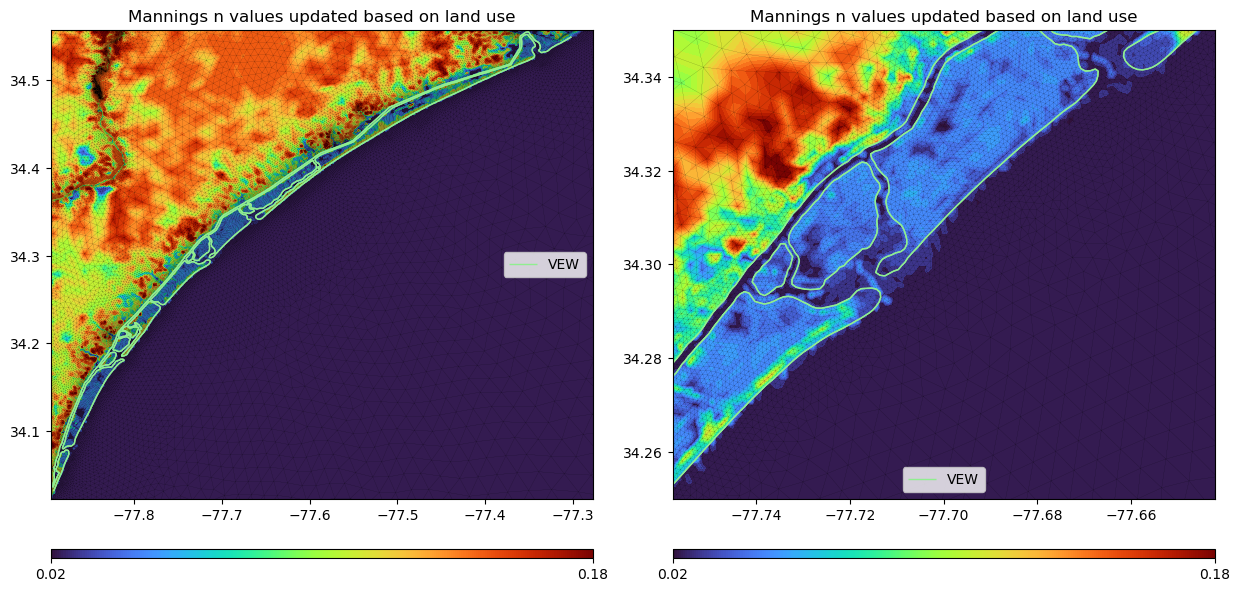

In [25]:
axes = plot_mannings_n('output/ch_noch_bg_lb_adjusted2.14', 'output/ch_noch_bg_lb_adjusted2_mn_updated.13', drawvew=True, cmap='turbo', vmin=0.02, vmax=0.18, title='Mannings n values updated based on land use')

## Summary

In this notebook, we have demonstrated the complete workflow for generating a mesh with VEWs from channel, land, and background meshes. The process included:

1. Combining channel and non-channel meshes with VEWs
2. Combining channel and non-channel meshes by merging overlapping nodes
3. Subtracting channel + non-channel coverage from background
4. Merging channel, non-channel, and subtracted background
5. Adding land boundaries to the merged mesh
6. Ensuring elevations of VEW channel nodes to be lower than bank nodes
7. Adjusting VEW barrier heights to be above the bank nodes
8. Copying nodal attributes in the background mesh to the new mesh
9. Updating Manning's n values in the new mesh
   - Selecting channel mesh nodes
   - Updating Manning's n values at the selected nodes

The final mesh is now ready for use in ADCIRC simulations with proper representation of channels, non-channel areas, and VEW boundaries.